<a href="https://colab.research.google.com/github/gatherheart/Classification_With_BERT/blob/main/Khaii_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3
!pip install torch

     |████████████████████████████████| 55.0MB 104kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 5.7MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp36-cp36m-linux_x86_64.whl size=588518 sha256=e6de9ff7514c19cb248faee6afd22ebc42cf9968873c0f7fdfcb95c16fe4cf9a
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.1MB 4.1MB/s 
     |████████████████████████████████| 757kB 3.9MB/s 
     |████████████████████████████████| 890kB 56.0MB/s 
     |████████████████████████████████| 3.0MB 51.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=172ad6fb45b734c9166e39e4c5cafebd37641ff6bbea5ba2e1abb8037bdaf9ee
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a501

In [4]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-zybqrbom
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-zybqrbom
  Created wheel for kobert: filename=kobert-0.1.2-cp36-none-any.whl size=12734 sha256=74ed5c0a5dd6208a1b6cddde7db4c43995a244fa78340d6077d0fc403a4cc685
  Stored in directory: /tmp/pip-ephem-wheel-cache-un09o4rl/wheels/a2/b0/41/435ee4e918f91918be41529283c5ff86cd010f02e7525aecf3
Successfully built kobert


In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook, notebook

In [6]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from gluonnlp.data import SentencepieceTokenizer

In [7]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

In [8]:
BASE_PATH = '/content/drive/MyDrive/hyun_data'

In [9]:
data_2019 = glob.glob(BASE_PATH+'/crawling/NewsResult_2019*')

In [10]:
data_2019

['/content/drive/MyDrive/hyun_data/crawling/NewsResult_20190801-20190810.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20190721-20190731.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20190711-20190720.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20190811-20190820.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20190821-20190831.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20190901-20190910.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20190921-20190930.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20190911-20190920.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20190701-20190710.csv']

In [11]:
data_2020 = glob.glob(BASE_PATH+'/crawling/NewsResult_2020*')

In [12]:
data_2020

['/content/drive/MyDrive/hyun_data/crawling/NewsResult_20200711-20200720.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20200701-20200710.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20200721-20200731.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20200801-20200810.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20200811-20200820.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20200821-20200831.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20200901-20200910.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20200911-20200920.csv',
 '/content/drive/MyDrive/hyun_data/crawling/NewsResult_20200921-20200930.csv']

In [13]:
df = pd.concat(map(lambda x: pd.read_csv(x), data_2019))

In [14]:
df

,0,뉴스 식별자,일자,단어,본문
0,1,2.100601e+06,20190810,"수,다,사진,다나,인스타그램,가수,모습,공개,다,일,오후,자신,사회,관계,망,서비스...","['\n', '\n', '\n', '\n', '\n', '가수 다나/사진=다나 인스..."
1,2,2.100601e+06,20190810,"왓,사진,방송,영상,캡처,진,범,비리장부,서강준,습격,일,방송,주말드라,왓,김영군,...","['\n', '\n', '\n', '\n', '\n', '\n', '왓쳐 (사진=방..."
2,3,2.100601e+06,20190810,"호텔,델루,사진,방송,영상,캡처,호텔,델루,남,우물,신,특,연,일,방송,토일,드라마...","['\n', '\n', '\n', '\n', '\n', '\n', '호텔 델루나 (..."
3,4,2.100601e+06,20190810,"오승환,사진,연합,뉴스,돌부,처,오승환,정팀,삼성,라이온즈,유니폼,오승환,일,대구,...","['\n', '\n', '\n', '\n', '\n', '오승환/사진=연합뉴스', ..."
4,5,2.100601e+06,20190810,"호텔,델루,사진,방송,영상,캡처,여,진,구,개장,호텔,델루나,이지,일,오후,방송,호...","['\n', '\n', '\n', '\n', '\n', '\n', '호텔 델루나 (..."
...,...,...,...,...,...
914,915,2.100601e+06,20190709,"사진,연합,뉴스,일본,정부,한국,경제,보복,조치,대북제재,위반,의혹,들,청와대,강경...","['\n', '\n', '\n', '\n', '\n', '사진=연합뉴스', '\n'..."
915,916,2.100601e+06,20190709,"이낙연,국무총리,한국,수출,규제,북한,연결,일본,아베,총리,발언,위험,발언,말,총리...","['\n', '\n', '\n', '\n', '\n', '\n', '\n ..."
916,917,2.100601e+06,20190709,"양호석,차오름,사진,양호석,차오름,인스타그램,양호석,차오름,진흙탕,폭로전,일,서울중...","['\n', '\n', '\n', '\n', '\n', '양호석, 차오름/사진=양호..."
917,918,2.100601e+06,20190709,"경기,용인시,시청,개,구청,개,읍,면,동,동시,실시간,연결,영상회,시스템,구축,시정...","['\n', '경기 용인시는 시청과 ', '3', '개 구청', ', 31', '개..."


In [15]:
df['단어'] =  list(map(lambda x: str(x).replace(',', ' '), df['단어']))

In [16]:
df = df.reset_index().drop(['0'], axis=1)

In [17]:
df.head(5)

,index,뉴스 식별자,일자,단어,본문
0,0,2.100601e+06,20190810,수 다 사진 다나 인스타그램 가수 모습 공개 다 일 오후 자신 사회 관계 망 서비스...,"['\n', '\n', '\n', '\n', '\n', '가수 다나/사진=다나 인스..."
1,1,2.100601e+06,20190810,왓 사진 방송 영상 캡처 진 범 비리장부 서강준 습격 일 방송 주말드라 왓 김영군 ...,"['\n', '\n', '\n', '\n', '\n', '\n', '왓쳐 (사진=방..."
2,2,2.100601e+06,20190810,호텔 델루 사진 방송 영상 캡처 호텔 델루 남 우물 신 특 연 일 방송 토일 드라마...,"['\n', '\n', '\n', '\n', '\n', '\n', '호텔 델루나 (..."
3,3,2.100601e+06,20190810,오승환 사진 연합 뉴스 돌부 처 오승환 정팀 삼성 라이온즈 유니폼 오승환 일 대구 ...,"['\n', '\n', '\n', '\n', '\n', '오승환/사진=연합뉴스', ..."
4,4,2.100601e+06,20190810,호텔 델루 사진 방송 영상 캡처 여 진 구 개장 호텔 델루나 이지 일 오후 방송 호...,"['\n', '\n', '\n', '\n', '\n', '\n', '호텔 델루나 (..."


In [18]:
df.iloc[9]['본문']

'[\'\\n\', \'\\n\', \'\\n\', \'\\n\', \'\\n\', \'일본 DHC/사진=JTBC\', \'\\n\', \'\\n                        일본 유명 화장품업체인 DHC의 자회사인 방송국이 혐한 방송을 진행, 논란이 일고 있다.\', "JTBC는 10일 DHC의 자회사 \'DHC텔레비선\'의 한 프로그램에서 한국의 불매운동을 비하하고 역사왜곡 발언을 했다고 보도했다.", \'보도에 따르면 이 방송에 출연한 한 패널은 "한국은 원래 금방 뜨거워지고 금방 식는 나라니까. 일본은 그냥 조용히 두고 봐야지"라며 한국의 일본상품 불매운동을 비하했다.\', \'또 다른 패널은 "\\\'조센징\\\'들은 한문을 썼는데 한문을 문자화시키지 못해서, 일본에서 만든 교과서로 한글을 배포했다. 일본인이 한글을 통일시켜서 지금의 한글이 됐다"고 역사왜곡 발언을 했다.\', "더불어 인터넷을 기반으로 하는 \'DHC텔레비전\'은 단순한 자회사가 아니라 중간 중간 자사 화장품 광고도 내보내는 등 해당 브랜드와 밀접한 관련을 맺고 있다.", \'나아가 요시다 요시아키 DHC 회장은 과거 재일동포를 비하하거나 극우 정당을 지원했다는 논란 등으로 비판을 받기도 했다.\', \'김정호 한경닷컴 기자 newsinfo@hankyung.com\\n\\t\\t\\t\\t\\t\\t\\t\\t\']'

In [19]:
NUM_LABELS = 58

## Data Preparation

In [20]:
sentences = df['단어'].values
sentences[:10]

array(['수 다 사진 다나 인스타그램 가수 모습 공개 다 일 오후 자신 사회 관계 망 서비스 살맛 글 사진 게재 공개 사진 티셔츠 모자 모습 최근 감량 이목 턱선 자랑 체중 유지 눈길 타운 라이브 인 도쿄 무대 김정호 한경닷컴 기자',
       '왓 사진 방송 영상 캡처 진 범 비리장부 서강준 습격 일 방송 주말드라 왓 김영군 서강준 아버지 김재명 안길 강 비밀 장부 진 범 모습 날 김영군 자신 운동화 깔창 김재명 비밀 장부 도치 광 한석규 에 연락 도 치광 한태주 김현주 김영군 집 그동안 김영군 파일 확인 김영군 파일 양시 검찰 지검장 민영기 마약 영상 김영군 집 물 김영군 물소리 거실 때 진범 김영군 목 끈 습격 진범 비밀 장부 노트북 화장실 욕조 가위 김영군 김영군 총 진범 김영군 총 끈 문고리 목 끈 집 밖 진범 아무것 후 도 치광 태주 도착 김영군 진범 습격 도치광 장부 김영군 발견 답 태 주 김영군 집 진 범 가위 충격 모습 한편 주말드라 왓 오후 시 방송 박미라 한경닷컴 연예 이 슈 팀 기자 기사제 보 보도 자료',
       '호텔 델루 사진 방송 영상 캡처 호텔 델루 남 우물 신 특 연 일 방송 토일 드라마 호텔 델루 우물 신 대동 정신 남 장 월 이지 구찬 여 진 구 과 모습 날 장 월 호텔 곳 유명 막걸리 들 산책 우물 신령 대동정신 과 신 령 집 영 달 객 잔 대동 정신 장 월 막걸리 맛 우물 신 물맛 군 대꾸 이후 구찬 장 월 호텔 방문 호텔 문 앞 신령 신령 존재 구찬 대동 정신 귀신 손 문 대동 정신 구찬 호텔 물바다 장 월 구찬 신령 일 신령 화 인간 구 찬성 요구 장 월 만류 구 찬성 신 령 구찬 대동 정신 두려움 토로 구찬 신 령 구찬 고마움 구 찬성 구찬 마음 속 감정 한편 토일 드라마 호텔 델루 오후 시 방송 박미라 경닷컴 연예 이 슈 팀 기자 기사 제보 보도 자료',
       '오승환 사진 연합 뉴스 돌부 처 오승환 정팀 삼성 라이온즈 유니폼 오승환 일 대구 라이온즈파크 라팍 방문 삼성 타 이거 즈 전 임대기

In [21]:
#dummy label
labels = [0 for _ in range(len(sentences))]

In [22]:
dataset = pd.DataFrame({'sentence': sentences, 'label': labels}, columns=['sentence', 'label'])

In [23]:
target_dataset = dataset.values
target_dataset

array([['수 다 사진 다나 인스타그램 가수 모습 공개 다 일 오후 자신 사회 관계 망 서비스 살맛 글 사진 게재 공개 사진 티셔츠 모자 모습 최근 감량 이목 턱선 자랑 체중 유지 눈길 타운 라이브 인 도쿄 무대 김정호 한경닷컴 기자',
        0],
       ['왓 사진 방송 영상 캡처 진 범 비리장부 서강준 습격 일 방송 주말드라 왓 김영군 서강준 아버지 김재명 안길 강 비밀 장부 진 범 모습 날 김영군 자신 운동화 깔창 김재명 비밀 장부 도치 광 한석규 에 연락 도 치광 한태주 김현주 김영군 집 그동안 김영군 파일 확인 김영군 파일 양시 검찰 지검장 민영기 마약 영상 김영군 집 물 김영군 물소리 거실 때 진범 김영군 목 끈 습격 진범 비밀 장부 노트북 화장실 욕조 가위 김영군 김영군 총 진범 김영군 총 끈 문고리 목 끈 집 밖 진범 아무것 후 도 치광 태주 도착 김영군 진범 습격 도치광 장부 김영군 발견 답 태 주 김영군 집 진 범 가위 충격 모습 한편 주말드라 왓 오후 시 방송 박미라 한경닷컴 연예 이 슈 팀 기자 기사제 보 보도 자료',
        0],
       ['호텔 델루 사진 방송 영상 캡처 호텔 델루 남 우물 신 특 연 일 방송 토일 드라마 호텔 델루 우물 신 대동 정신 남 장 월 이지 구찬 여 진 구 과 모습 날 장 월 호텔 곳 유명 막걸리 들 산책 우물 신령 대동정신 과 신 령 집 영 달 객 잔 대동 정신 장 월 막걸리 맛 우물 신 물맛 군 대꾸 이후 구찬 장 월 호텔 방문 호텔 문 앞 신령 신령 존재 구찬 대동 정신 귀신 손 문 대동 정신 구찬 호텔 물바다 장 월 구찬 신령 일 신령 화 인간 구 찬성 요구 장 월 만류 구 찬성 신 령 구찬 대동 정신 두려움 토로 구찬 신 령 구찬 고마움 구 찬성 구찬 마음 속 감정 한편 토일 드라마 호텔 델루 오후 시 방송 박미라 경닷컴 연예 이 슈 팀 기자 기사 제보 보도 자료',
        0],
       ...,
       ['양호석 차오름 사진 양호석 차오름 인스타

In [24]:
tokenizer = get_tokenizer()
bertmodel, vocab = get_pytorch_kobert_model()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]
using cached model


In [25]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = []
        self.labels = []
        
        for i in dataset:
            try:
                self.sentences.append(transform([i[sent_idx]]))
                self.labels.append(np.int32(i[label_idx]))
            except Exception as e:
                print(e)
                print(len(self.sentences), len(self.labels))

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [26]:
target_data = BERTDataset(target_dataset, 0, 1, tok, 128, True, False)

In [27]:
dataloader = torch.utils.data.DataLoader(target_data, batch_size=64, num_workers=5)

## Classification

In [29]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=NUM_LABELS,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        return self.classifier(pooler)

In [30]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)
device = torch.device("cuda:0")

Sun Dec 13 14:17:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
model = BERTClassifier(bertmodel).to(device)

In [32]:
model.cuda()
model.load_state_dict(torch.load(BASE_PATH+"/bert_news_model_2020_12_13_04_55_15.pth"))
model.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [33]:
results = []

In [35]:
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length
    out = model(token_ids, valid_length, segment_ids)
    max_vals, max_indices = torch.max(out, 1)
    results.append(max_indices)

In [41]:
topics = []
for result in results:
    for i in result.data.cpu().numpy():
        topics.append(i)

In [42]:
topics

[0,
 20,
 0,
 37,
 37,
 0,
 2,
 48,
 46,
 19,
 48,
 14,
 0,
 48,
 55,
 2,
 0,
 14,
 0,
 1,
 0,
 0,
 48,
 0,
 0,
 19,
 0,
 0,
 0,
 14,
 0,
 30,
 15,
 0,
 25,
 0,
 9,
 0,
 0,
 1,
 0,
 0,
 30,
 0,
 0,
 0,
 30,
 44,
 0,
 0,
 0,
 0,
 0,
 37,
 20,
 48,
 9,
 30,
 0,
 0,
 0,
 0,
 0,
 0,
 30,
 14,
 0,
 9,
 2,
 0,
 7,
 0,
 33,
 9,
 35,
 1,
 32,
 19,
 1,
 39,
 15,
 9,
 1,
 41,
 0,
 20,
 0,
 0,
 0,
 3,
 41,
 7,
 39,
 0,
 28,
 13,
 13,
 6,
 30,
 13,
 0,
 46,
 0,
 0,
 0,
 0,
 0,
 0,
 49,
 10,
 49,
 52,
 2,
 13,
 49,
 0,
 0,
 0,
 0,
 0,
 0,
 39,
 0,
 0,
 0,
 0,
 15,
 0,
 5,
 48,
 0,
 39,
 0,
 10,
 24,
 13,
 49,
 14,
 8,
 50,
 2,
 2,
 9,
 49,
 5,
 9,
 50,
 50,
 46,
 0,
 9,
 8,
 0,
 0,
 11,
 33,
 9,
 40,
 47,
 0,
 10,
 0,
 0,
 0,
 0,
 10,
 39,
 0,
 11,
 37,
 2,
 0,
 41,
 20,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 20,
 0,
 0,
 2,
 0,
 30,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 30,
 0,
 0,
 17,
 17

In [43]:
labels_csv = pd.read_csv(BASE_PATH+'/labels_dict2.csv', index_col=[0])

In [44]:
text_to_label = dict(labels_csv)
label_to_text = {}
for label in text_to_label:
    label_to_text[int(text_to_label[label])] = label
label_to_text

{0: '문화>방송_연예',
 1: '국제>중국',
 2: '사회>사회일반',
 3: '정치>국회_정당',
 4: '사회>교육_시험',
 5: 'IT_과학>모바일',
 6: '정치>행정_자치',
 7: '사회>사건_사고',
 8: '문화>문화일반',
 9: '정치>청와대',
 10: '사회>여성',
 11: '국제>유럽_EU',
 12: '경제>자원',
 13: '국제>미국_북미',
 14: '사회>날씨',
 15: '사회>의료_건강',
 16: 'IT_과학>콘텐츠',
 17: '경제>증권_증시',
 18: '정치>선거',
 19: '국제>일본',
 20: '사회>미디어',
 21: '문화>음악',
 22: '국제>중남미',
 23: '국제>중동_아프리카',
 24: '경제>유통',
 25: '문화>출판',
 26: '경제>자동차',
 27: '사회>환경',
 28: '경제>금융_재테크',
 29: '사회>장애인',
 30: '문화>전시_공연',
 31: '경제>부동산',
 32: 'IT_과학>IT_과학일반',
 33: '문화>요리_여행',
 34: 'IT_과학>과학',
 35: '경제>서비스_쇼핑',
 36: '경제>외환',
 37: '미분류',
 38: '문화>미술_건축',
 39: '문화>생활',
 40: '경제>경제일반',
 41: '국제>아시아',
 42: '정치>정치일반',
 43: '경제>국제경제',
 44: '경제>취업_창업',
 45: 'IT_과학>보안',
 46: '정치>외교',
 47: '경제>무역',
 48: '문화>영화',
 49: '정치>북한',
 50: '경제>산업_기업',
 51: '문화>종교',
 52: '경제>반도체',
 53: '문화>학술_문화재',
 54: '사회>노동_복지',
 55: '국제>국제일반',
 56: 'IT_과학>인터넷_SNS',
 57: '국제>러시아'}

In [45]:
topics_converted = list(map(lambda x: label_to_text[x], topics))
topics_converted

['문화>방송_연예',
 '사회>미디어',
 '문화>방송_연예',
 '미분류',
 '미분류',
 '문화>방송_연예',
 '사회>사회일반',
 '문화>영화',
 '정치>외교',
 '국제>일본',
 '문화>영화',
 '사회>날씨',
 '문화>방송_연예',
 '문화>영화',
 '국제>국제일반',
 '사회>사회일반',
 '문화>방송_연예',
 '사회>날씨',
 '문화>방송_연예',
 '국제>중국',
 '문화>방송_연예',
 '문화>방송_연예',
 '문화>영화',
 '문화>방송_연예',
 '문화>방송_연예',
 '국제>일본',
 '문화>방송_연예',
 '문화>방송_연예',
 '문화>방송_연예',
 '사회>날씨',
 '문화>방송_연예',
 '문화>전시_공연',
 '사회>의료_건강',
 '문화>방송_연예',
 '문화>출판',
 '문화>방송_연예',
 '정치>청와대',
 '문화>방송_연예',
 '문화>방송_연예',
 '국제>중국',
 '문화>방송_연예',
 '문화>방송_연예',
 '문화>전시_공연',
 '문화>방송_연예',
 '문화>방송_연예',
 '문화>방송_연예',
 '문화>전시_공연',
 '경제>취업_창업',
 '문화>방송_연예',
 '문화>방송_연예',
 '문화>방송_연예',
 '문화>방송_연예',
 '문화>방송_연예',
 '미분류',
 '사회>미디어',
 '문화>영화',
 '정치>청와대',
 '문화>전시_공연',
 '문화>방송_연예',
 '문화>방송_연예',
 '문화>방송_연예',
 '문화>방송_연예',
 '문화>방송_연예',
 '문화>방송_연예',
 '문화>전시_공연',
 '사회>날씨',
 '문화>방송_연예',
 '정치>청와대',
 '사회>사회일반',
 '문화>방송_연예',
 '사회>사건_사고',
 '문화>방송_연예',
 '문화>요리_여행',
 '정치>청와대',
 '경제>서비스_쇼핑',
 '국제>중국',
 'IT_과학>IT_과학일반',
 '국제>일본',
 '국제>중국',
 '문화>생활',
 '사회>의료_건강',
 '정치>청와대',
 '국제>중국',
 '국제>아시아

In [52]:
topic_result = pd.Series(topics_converted).value_counts()

In [56]:
topic_result.index, topic_result.values

(Index(['문화>방송_연예', '경제>증권_증시', '문화>전시_공연', '경제>산업_기업', '경제>경제일반', '미분류',
        '문화>영화', '사회>사회일반', '사회>사건_사고', '정치>청와대', '경제>금융_재테크', '경제>부동산',
        'IT_과학>모바일', '경제>자동차', '사회>미디어', '국제>일본', '경제>유통', '사회>여성', 'IT_과학>과학',
        '경제>취업_창업', '경제>서비스_쇼핑', '정치>국회_정당', '경제>반도체', '사회>교육_시험', '국제>미국_북미',
        '경제>무역', '국제>중국', '정치>외교', '문화>출판', '문화>생활', '사회>노동_복지', '문화>문화일반',
        '문화>요리_여행', '사회>날씨', '정치>행정_자치', '정치>정치일반', 'IT_과학>IT_과학일반',
        '문화>학술_문화재', '정치>북한', 'IT_과학>콘텐츠', '경제>국제경제', '사회>의료_건강', '경제>외환',
        '경제>자원', '국제>유럽_EU', '국제>아시아', '문화>미술_건축', 'IT_과학>인터넷_SNS', '문화>음악',
        '국제>국제일반', '국제>중동_아프리카', '사회>장애인', '사회>환경', 'IT_과학>보안', '국제>중남미',
        '문화>종교', '국제>러시아'],
       dtype='object'),
 array([2099, 1447,  412,  367,  362,  284,  248,  242,  233,  204,  202,
         192,  182,  179,  162,  158,  157,  122,  119,  105,  105,  102,
         101,   92,   90,   88,   79,   79,   76,   76,   75,   74,   62,
          60,   58,   58,   57,   51,   48,   48,

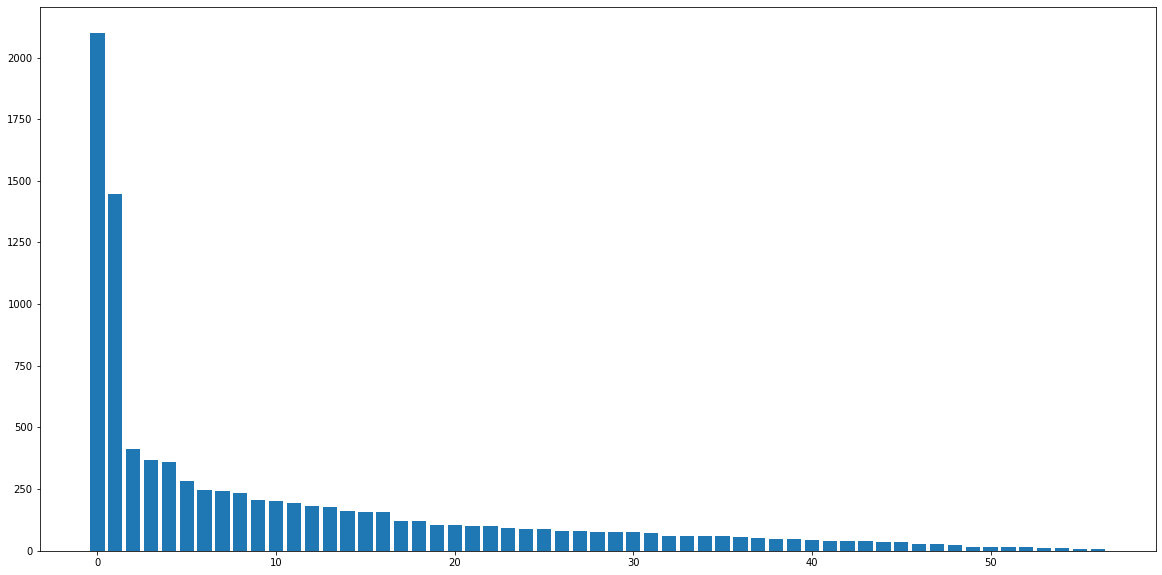

In [59]:
plt.figure(figsize=(20,10))
plt.bar(range(len(topic_result.index)), topic_result.values)
plt.show()

In [60]:
!pip install textrankr

In [65]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 360kB/s 
     |████████████████████████████████| 92kB 12.1MB/s 
     |████████████████████████████████| 460kB 64.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [63]:
df['토픽'] = topics

In [70]:
text_to_label['문화>방송_연예'].values

array([0])

In [72]:
target_topic = df[df['토픽'] == text_to_label['문화>방송_연예'].values[0]]
target_topic.head()

,index,뉴스 식별자,일자,단어,본문,토픽
0,0,2.100601e+06,20190810,수 다 사진 다나 인스타그램 가수 모습 공개 다 일 오후 자신 사회 관계 망 서비스...,"['\n', '\n', '\n', '\n', '\n', '가수 다나/사진=다나 인스...",0
2,2,2.100601e+06,20190810,호텔 델루 사진 방송 영상 캡처 호텔 델루 남 우물 신 특 연 일 방송 토일 드라마...,"['\n', '\n', '\n', '\n', '\n', '\n', '호텔 델루나 (...",0
5,5,2.100601e+06,20190810,토요일 도 레미마켓 사진 방송 영상 캡처 태연 써니 악동 뮤지션 천상지 희 가사 성...,"['\n', '\n', '\n', '\n', '\n', '\n', '놀라운 토요일-...",0
12,12,2.100601e+06,20190810,배틀 트립 사진 제공 배틀 트립 출연 재민 노 드라마 도깨비 패러디 오늘 일 방송 ...,"['\n', '\n', '\n', '\n', '\n', '\n', '배틀트립 (사진...",0
16,16,2.100601e+06,20190810,토요일 도 레미마켓 사진 방송 영상 캡처 소녀 시대 태연 악동 뮤지션 노래 가사 자...,"['\n', '\n', '\n', '\n', '\n', '\n', '놀라운 토요일-...",0


In [101]:
import re

In [102]:
target_text = target_topic.iloc[0]['본문']

In [113]:
target_text = target_text[85:]

In [115]:
target_text = re.sub('[^0-9a-zA-Zㄱ-힗]', ' ', target_text)

In [116]:
from typing import List
from konlpy.tag import Okt

class OktTokenizer:
    okt: Okt = Okt()

    def __call__(self, text: str) -> List[str]:
        tokens: List[str] = self.okt.phrases(text)
        return tokens

In [117]:
from typing import List
from textrankr import TextRank

mytokenizer: OktTokenizer = OktTokenizer()
textrank: TextRank = TextRank(mytokenizer)

k: int = 3  # num sentences in the resulting summary

summarized: str = textrank.summarize(str(target_text), k)
print(summarized)

# if verbose=False, it returns a list
summaries: List[str] = textrank.summarize(str(target_text), k, verbose=False)
for summary in summaries:
    print(summary)

가수 다나가 몰라보게 달라진 모습을 공개했다      다나는 지난 9일 오후 자신의 사회관계망서비스 SNS 를 통해  살맛이 난다 는 글과 함께 한 장의 사진을 게재했다      공개된 사진에서 다나는 티셔츠에 모자를 쓴 모습이다  최근 27kg을 감량하며 이목을 끌었던 다나는 날렵한 턱선까지 자랑하고 있다      아울러 여전히 체중을 유지하고 있어 눈길을 끌기 있다     한편  다나는  SM타운 라이브 2019 인 도쿄 의 무대에 올랐다     김정호 한경닷컴 기자 newsinfo hankyung com n t t t t t t t t
가수 다나가 몰라보게 달라진 모습을 공개했다      다나는 지난 9일 오후 자신의 사회관계망서비스 SNS 를 통해  살맛이 난다 는 글과 함께 한 장의 사진을 게재했다      공개된 사진에서 다나는 티셔츠에 모자를 쓴 모습이다  최근 27kg을 감량하며 이목을 끌었던 다나는 날렵한 턱선까지 자랑하고 있다      아울러 여전히 체중을 유지하고 있어 눈길을 끌기 있다     한편  다나는  SM타운 라이브 2019 인 도쿄 의 무대에 올랐다     김정호 한경닷컴 기자 newsinfo hankyung com n t t t t t t t t
